In [11]:
!wget "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz"
!wget "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz"
!wget "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz"
!wget "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz"
!wget "http://codh.rois.ac.jp/kmnist/dataset/k49/k49_classmap.csv"

--2023-09-02 14:28:32--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66117696 (63M)
Saving to: ‘k49-train-imgs.npz’

k49-train-imgs.npz  100%[===================>]  63.05M  1.69MB/s    in 39s     

2023-09-02 14:29:12 (1.61 MB/s) - ‘k49-train-imgs.npz’ saved [66117696/66117696]

--2023-09-02 14:29:12--  http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164485 (161K)
Saving to: ‘k49-train-labels.npz’

k49-train-labels.np 100%[===================>] 160.63K   366KB/s    in 0.4s    

2023-09-02 14:29:13 (366 KB/s) - ‘k49-train-labels.npz’ saved [164485/164485]

--2023-09-02 1

In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import random
import pickle
import time
import tensorflow as tf

from google.colab import files
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from IPython.display import display, clear_output
from typing import List

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


### Loading the data

In [2]:
# Loading the train data
images = np.load('k49-train-imgs.npz')['arr_0']
labels = np.load('k49-train-labels.npz')['arr_0']

# Loading the test
test_images = np.load("k49-test-imgs.npz")['arr_0']
test_labels = np.load("k49-test-labels.npz")['arr_0']

print("Train data: ", images.shape, labels.shape)
print("Test data: ", test_images.shape, test_labels.shape)

Train data:  (232365, 28, 28) (232365,)
Test data:  (38547, 28, 28) (38547,)


In [3]:
# Loading the class mapping
class_map = np.array(pd.read_csv("k49_classmap.csv")['char'])
class_map

array(['あ', 'い', 'う', 'え', 'お', 'か', 'き', 'く', 'け', 'こ', 'さ', 'し', 'す',
       'せ', 'そ', 'た', 'ち', 'つ', 'て', 'と', 'な', 'に', 'ぬ', 'ね', 'の', 'は',
       'ひ', 'ふ', 'へ', 'ほ', 'ま', 'み', 'む', 'め', 'も', 'や', 'ゆ', 'よ', 'ら',
       'り', 'る', 'れ', 'ろ', 'わ', 'ゐ', 'ゑ', 'を', 'ん', 'ゝ'], dtype=object)

In [4]:
# Checking the number of classes
NUM_CLASSES = len(np.unique(labels))

# Checking if the labels inside training data and testing data are the same
assert len(set(np.unique(labels)).difference(set(np.unique(test_labels)))) == 0

print("Number of unique classes: ", NUM_CLASSES)

Number of unique classes:  49


### Checking the distribution of the data

Text(0, 0.5, 'Number of elements')

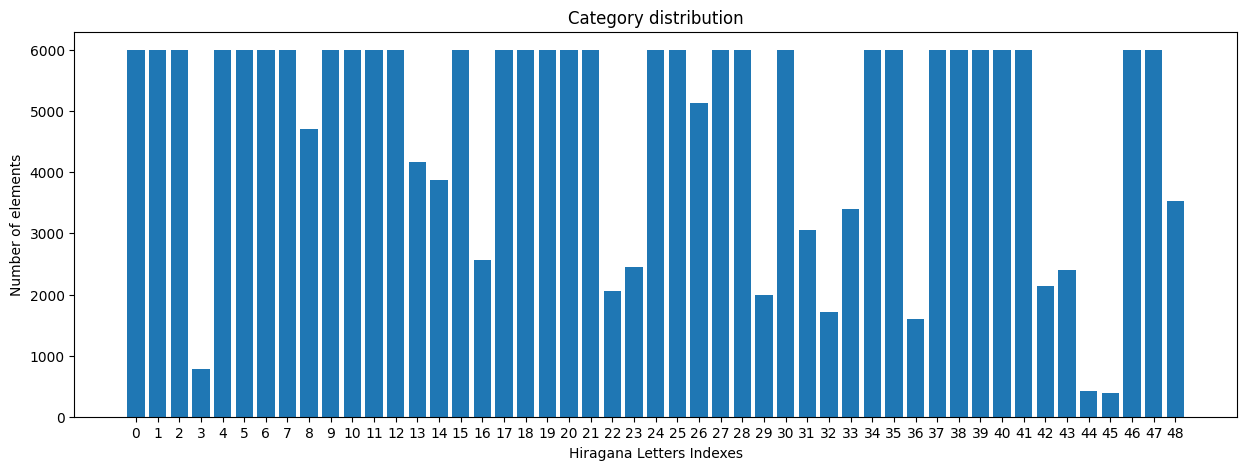

In [5]:
plt.figure(figsize=(15, 5))
plt.bar(np.unique(labels), np.bincount(labels), tick_label=[str(i) for i in range(NUM_CLASSES)])
plt.title("Category distribution")
plt.xlabel("Hiragana Letters Indexes")
plt.ylabel("Number of elements")

From the above plot, we can observe a clear data imbalance, specifically for class 3, 44 and 45. So, we will perform some data augmentations to generate new data from the existing data.

### Data Augmentation

In [6]:
def augment_images(images: List[np.ndarray], n: int) -> List[np.ndarray]:
    """
    Augments a list of grayscale images by applying various transformations.

    Parameters:
        images (List[np.ndarray]): List of input grayscale images.
        n (int): Number of augmentations to generate per input image.

    Returns:
        List[np.ndarray]: List of augmented grayscale images.
    """
    # Create an image data generator with specified augmentation settings
    augmenter = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.3,
        width_shift_range=0.3,
        fill_mode='constant'
    )

    augmented_images = []
    for image in images:
        # Convert grayscale to BGR
        color_image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        # Generate augmented images
        augmented_generator = augmenter.flow(np.array([color_image] * n))
        # Convert augmented images back to grayscale and add to the list
        augmented_images.extend([cv.cvtColor(augmented, cv.COLOR_BGR2GRAY) for augmented in next(augmented_generator)])

    return augmented_images

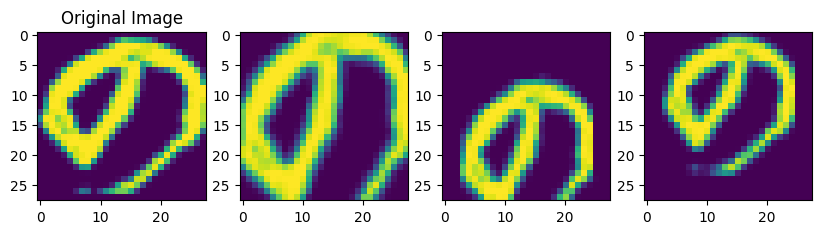

In [7]:
# Visualization of the augment_images

_image = images[10]
_augumented_image = augment_images([_image], 3)

_, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(_image)
ax[0].title.set_text("Original Image")

ax[1].imshow(_augumented_image[0])
ax[2].imshow(_augumented_image[1])
ax[3].imshow(_augumented_image[2])

plt.show()

### Data Preprocessing

Since our data have heavy imbalance below prcess will serves the purpose of balancing an image dataset, along with their associated labels, to create a well-rounded training set for machine learning:

#### The process executes as follows:

- For each distinct label in the dataset:
  - Accumulate all images belonging to the current label's class.
  - In case the count of images for the current class falls short of a predetermined threshold (`CATEGORY_DATA_LEN`), the code embarks on an augmentation process. This involves employing the augment_images function to produce augmented versions of these images.
  - `AUGMENTATION_SAMPLES` defines the number of augmented images to be generated for a single image.
  - Meld the original images with the augmented ones to achieve a total of `CATEGORY_DATA_LEN` samples for the class.
  - Append the processed images to the `X_train` array.
  - Corresponding to these images, append labels to the `y_train` array, replicating the current class label as needed.

This process essentially targets the issue of class imbalance by generating extra instances for classes that have an insufficient representation. The result is a meticulously balanced dataset that is well-suited for training machine learning models.

##### Data Augmentation

In [8]:
CATEGORY_DATA_LEN = 1000
AUGMENTATION_SAMPLES = 2

# Initialize arrays for training images and labels
X_train = np.empty((0, 28, 28), np.uint8)
y_train = np.empty((0), int)

# Iterate through unique labels in the dataset
for i in np.unique(labels):
    # Extract images belonging to the current class
    class_images = images[np.where(labels == i)[0]]
    # Check if the current class has fewer images than required amount
    if len(class_images) < CATEGORY_DATA_LEN:
        while len(class_images) <= CATEGORY_DATA_LEN:
          # Augment images
          augumented_images = augment_images(class_images, AUGMENTATION_SAMPLES)
          # Calculate the number of additional images needed
          images_needed = CATEGORY_DATA_LEN - len(class_images)
          # Combine original and augmented images
          class_images = np.concatenate([class_images, augumented_images], axis=0)

    # Combining existing images and augmented images
    X_train = np.concatenate([X_train, class_images[:CATEGORY_DATA_LEN]], axis=0)  # Append images to X_train
    y_train = np.concatenate([y_train, np.repeat(i, CATEGORY_DATA_LEN)])  # Append labels to y_train

assert X_train.shape[0] == y_train.shape[0]
print("Total Data for training: ", X_train.shape, y_train.shape)

Total Data for training:  (49000, 28, 28) (49000,)


Text(0, 0.5, 'Number of elements')

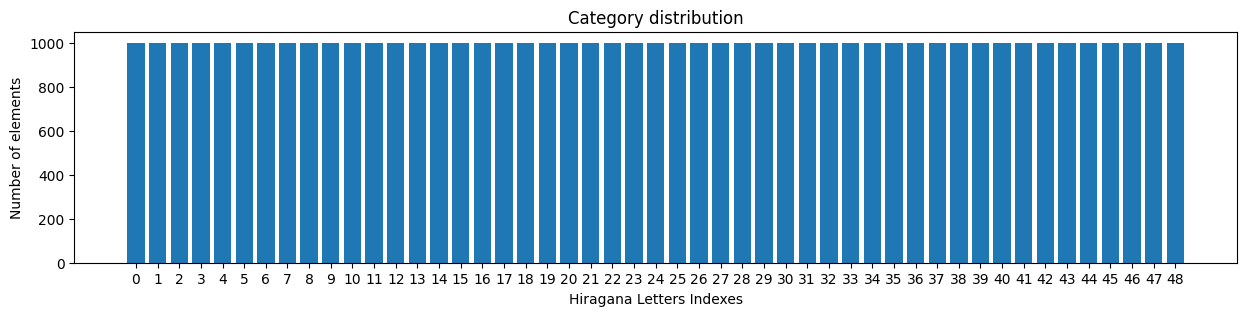

In [9]:
# Updated distribution

plt.figure(figsize=(15, 3))
plt.bar(np.unique(y_train), np.bincount(y_train), tick_label=[str(i) for i in range(NUM_CLASSES)])
plt.title("Category distribution")
plt.xlabel("Hiragana Letters Indexes")
plt.ylabel("Number of elements")

#### Train and validation split

In [10]:
# Shuffle the data
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = np.array(X_train[indices])
y_train = np.array(y_train[indices])

# Train and Validation split
split_80 = int(X_train.shape[0]*0.80)

X_valid = X_train[split_80:]
y_valid = y_train[split_80:]

X_train = X_train[:split_80]
y_train = y_train[:split_80]


print("Train data: ", X_train.shape, y_train.shape)
print("Validation data: ", X_valid.shape, y_valid.shape)

Train data:  (39200, 28, 28) (39200,)
Validation data:  (9800, 28, 28) (9800,)


#### Data Normalization and Label transformation

In [11]:
def x_norm_y_transform(X, y):
    """
    Normalize input data and transform labels to one-hot encoding.
    Parameters:
        X (numpy.ndarray): Input data.
        y (numpy.ndarray): Labels.
    Returns:
        numpy.ndarray, numpy.ndarray: Normalized data, one-hot encoded labels.
    """
    # Normalize input data by dividing by 255
    X_normalized = X / 255
    # Transform labels to one-hot encoding
    y_one_hot = to_categorical(y)
    return X_normalized, y_one_hot

X_test, y_test = x_norm_y_transform(test_images, test_labels)
X_valid, y_valid = x_norm_y_transform(X_valid, y_valid)
X_train, y_train = x_norm_y_transform(X_train, y_train)

### Building the model

 We will be using a simple sequential deep learning model for Hiragana letter classification.

 The model architecture consists of fully connected layers followed by batch normalization to enhance training stability. The last layer utilizes softmax activation to predict among 49 classes,

In [12]:
def build_seq_model():
  """
  Build a sequential deep learning model for
  Hiragana letter classification.

  Returns:
      tf.keras.Model: Constructed sequential model.
  """
  model = tf.keras.Sequential(
      [
          tf.keras.Input(shape=(28, 28)),
          tf.keras.layers.Flatten(),

          tf.keras.layers.Dense(1024, activation='relu'),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(1024, activation='relu'),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.1),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.1),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(49, activation='softmax')
      ]
  )
  return model

In [13]:
# Building the model
model = build_seq_model()
print("Model Summary: ", model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

In [17]:
# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Model Training

In [14]:
# Train config
EPOCHS = 5
BATCH_SIZE = 128

### TPU Training

In [15]:
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  model = build_seq_model()
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start = time.time()
model_hist = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid))
print("Training time: ", time.time()-start)


Epoch 1/5
307/307 [==============================] - 25s 40ms/step - loss: 3.1394 - accuracy: 0.2002 - val_loss: 1.9097 - val_accuracy: 0.4992
Epoch 2/5
307/307 [==============================] - 7s 23ms/step - loss: 2.2566 - accuracy: 0.4015 - val_loss: 1.4672 - val_accuracy: 0.6154
Epoch 3/5
307/307 [==============================] - 8s 26ms/step - loss: 1.9497 - accuracy: 0.4785 - val_loss: 1.2775 - val_accuracy: 0.6605
Epoch 4/5
307/307 [==============================] - 7s 23ms/step - loss: 1.7701 - accuracy: 0.5271 - val_loss: 1.1115 - val_accuracy: 0.7012
Epoch 5/5
307/307 [==============================] - 7s 21ms/step - loss: 1.6489 - accuracy: 0.5544 - val_loss: 1.0239 - val_accuracy: 0.7272
Training time:  55.715585708618164


### GPU Training

In [22]:
device_name = tf.test.gpu_device_name()
print("Device in use: ", device_name)

start = time.time()
with tf.device('/device:GPU:0'):
  # Model fit
  model_hist = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid))

print("Training time: ", time.time()-start)

Device in use:  /device:GPU:0


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
307/307 [==============================] - 60s 184ms/step - loss: 2.6026 - accuracy: 0.3502 - val_loss: 1.3833 - val_accuracy: 0.6326
Epoch 2/5
307/307 [==============================] - 69s 224ms/step - loss: 1.4754 - accuracy: 0.6115 - val_loss: 0.9986 - val_accuracy: 0.7284
Epoch 3/5
307/307 [==============================] - 59s 192ms/step - loss: 1.1631 - accuracy: 0.6907 - val_loss: 0.8277 - val_accuracy: 0.7720
Epoch 4/5
307/307 [==============================] - 57s 185ms/step - loss: 0.9964 - accuracy: 0.7309 - val_loss: 0.7505 - val_accuracy: 0.7966
Epoch 5/5
307/307 [==============================] - 57s 185ms/step - loss: 0.8781 - accuracy: 0.7618 - val_loss: 0.7001 - val_accuracy: 0.8111
Training time:  322.3540415763855


### CPU Training

In [23]:
start = time.time()

with tf.device('/cpu:0'):
  # Model fit
  model_hist = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid))

print("Training time: ", time.time()-start)


Epoch 1/5
307/307 [==============================] - 101s 323ms/step - loss: 0.7950 - accuracy: 0.7827 - val_loss: 0.6448 - val_accuracy: 0.8281
Epoch 2/5
307/307 [==============================] - 100s 326ms/step - loss: 0.7260 - accuracy: 0.8007 - val_loss: 0.5935 - val_accuracy: 0.8432
Epoch 3/5
307/307 [==============================] - 98s 321ms/step - loss: 0.6699 - accuracy: 0.8177 - val_loss: 0.5772 - val_accuracy: 0.8488
Epoch 4/5
307/307 [==============================] - 100s 326ms/step - loss: 0.6248 - accuracy: 0.8302 - val_loss: 0.5576 - val_accuracy: 0.8512
Epoch 5/5
307/307 [==============================] - 100s 324ms/step - loss: 0.5950 - accuracy: 0.8348 - val_loss: 0.5299 - val_accuracy: 0.8622
Training time:  502.0925302505493


### Model Evaluation

#### Loss and Epoch graph

Text(0, 0.5, 'Loss')

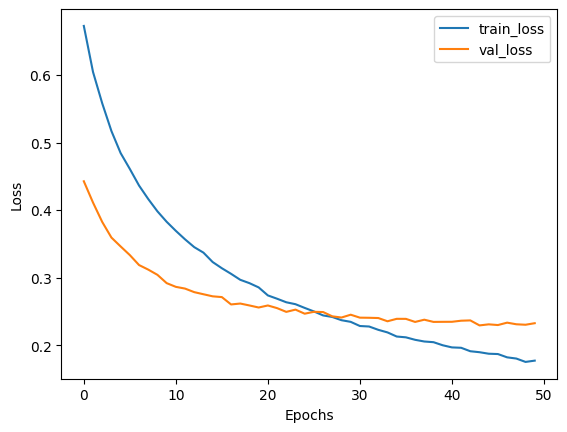

In [ ]:
plt.plot(model_hist.epoch, model_hist.history['loss'])
plt.plot(model_hist.epoch, model_hist.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Accuracy and Epoch graph

Text(0, 0.5, 'Accuracy')

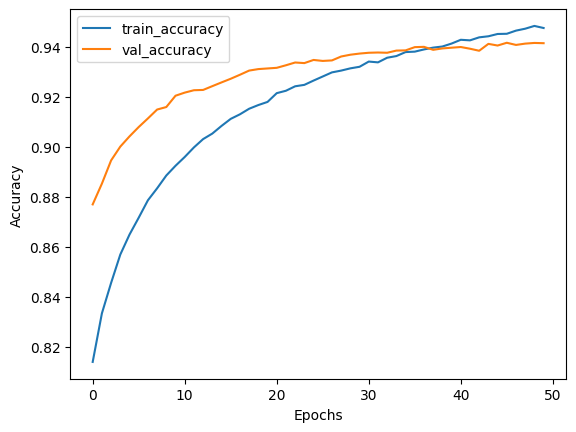

In [ ]:
plt.plot(model_hist.epoch, model_hist.history['accuracy'])
plt.plot(model_hist.epoch, model_hist.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

#### Model's performance on the test data

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Loss and Accuracy: ", test_loss, test_accuracy)

1205/1205 [==============================] - 35s 29ms/step - loss: 0.3942 - accuracy: 0.9123
Loss and Accuracy:  0.39417925477027893 0.9123148322105408


#### Confusion matrix on the test data

In [ ]:
# Model prediction
y_pred = model.predict(X_test)
# Post processing the results
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Creating a data frame of confusion matrix
df_confusion = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
# Saving the csv of confusion matrix
df_confusion.to_csv('confusion_matrix.csv')

print("Confusion Matrix: ")
df_confusion

1205/1205 [==============================] - 23s 19ms/step
Confusion Matrix: 


Predicted,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,All
Actual,,,,,,,,,,,,,,,,,,,,,
0,913,3,1,0,2,0,0,0,2,2,...,1,1,8,2,0,2,3,0,0,1000
1,0,958,0,0,0,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,1000
2,0,0,961,0,0,12,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1000
3,0,0,0,114,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,2,126
4,2,1,0,1,930,4,0,0,0,0,...,2,4,0,0,0,0,6,0,0,1000
5,6,3,25,1,9,849,0,1,1,1,...,12,1,11,1,1,0,0,0,2,1000
6,0,0,1,1,1,0,895,0,19,1,...,1,6,0,0,0,1,5,0,0,1000
7,0,1,1,4,0,3,0,908,0,4,...,0,1,0,0,0,0,0,5,11,1000
8,2,1,0,0,1,3,7,0,704,0,...,1,0,0,0,0,1,6,3,0,767


In [ ]:
# Visualizing the test output
idx = 0
fig, ax = plt.subplots(5, 5, figsize=(15, 8))
for i in range(0, y_true.shape[0], 25):
  for j in range(5):
    for k in range(5):
      ax[j, k].imshow(X_test[idx], cmap="Greens" if y_true[idx]==y_pred[idx] else "Reds")
      ax[j, k].title.set_text(y_pred[idx])
      idx += 1

  display(fig)
  plt.pause(10)
  clear_output(wait = False)

KeyboardInterrupt: ignored

### Saving the model

In [ ]:
model.save('hiragana_classifier_v1.h5')

### Download all the necessry files to local system

In [ ]:
history_data = {
    "train_history": model_hist.history,
    "epochs": model_hist.epoch,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy
}

with open("train_history.pickle", "wb") as f:
  pickle.dump(history_data, f)

In [ ]:
# Download model
files.download('hiragana_classifier_v1.h5')
# Download model history
files.download('train_history.pickle')
# Download confusion metrix
files.download('confusion_matrix.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>